# Reverste Time Migration with Devito

This notebook showcases reverse time migration which is the core step behind FWI.

This notebook will show how create an image from the difference between our assumption and the true model of the velocity profile during a seismic survey.



# Set up the problem

We create a two layer velocity profile. This will be the true model. We create a secondary modell which will represent our assumption of the velocity profile.

The true model hase a clear reflective surface in the middle, while our assumption has a smoothed surface.

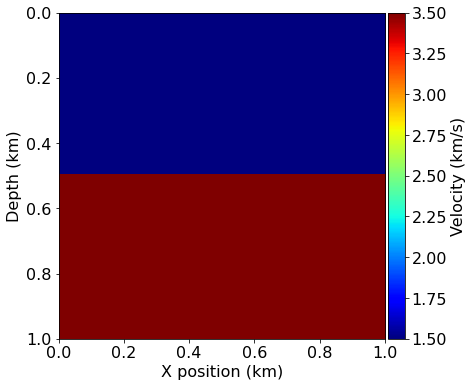

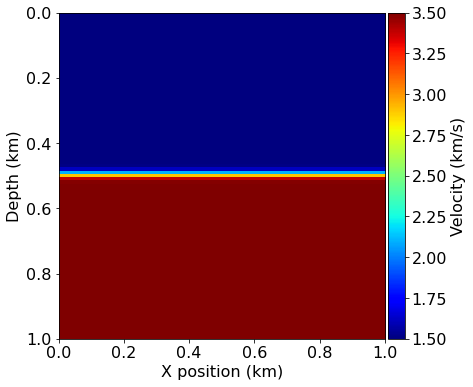

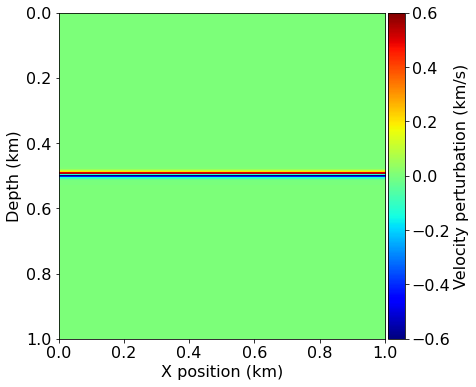

In [1]:
#NBVAL_IGNORE_OUTPUT
import numpy as np

from devito import configuration
configuration['log-level'] = 'WARNING'

# Configure model presets
from examples.seismic import demo_model

# Enable model presets here:
preset = 'layers-isotropic'  # A simple but cheap model (recommended)

# Standard preset with a simple two-layer model
if preset == 'layers-isotropic':
    def create_model(grid=None):
        return demo_model('layers-isotropic', origin=(0., 0.), shape=(101, 101),
                          spacing=(10., 10.), nbl=20, grid=grid, nlayers=2)
    filter_sigma = (1, 1)
    nshots = 21
    nreceivers = 101
    t0 = 0.
    tn = 1000.  # Simulation last 1 second (1000 ms)
    f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)



from examples.seismic import plot_velocity, plot_perturbation, plot_image
from devito import gaussian_smooth

# Create true model from a preset
model = create_model()

# Create initial model and smooth the boundaries
model0 = create_model(grid=model.grid)
gaussian_smooth(model0.vp, sigma=filter_sigma)

# Plot the true and initial model and the perturbation between them
plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)


Setting up the usual source and receiver setting:

In [2]:
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)

# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord


# START RTM
# Define gradient operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource


## True and smooth data

We can generate shotrecords from the smooth data and the true model. We see that the shotrecords have difference on signals coming from the reflective surface. We can use this information as the error term at a backpropagation to find the difference between our model and the true model.

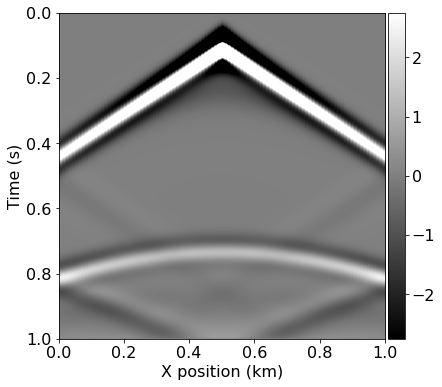

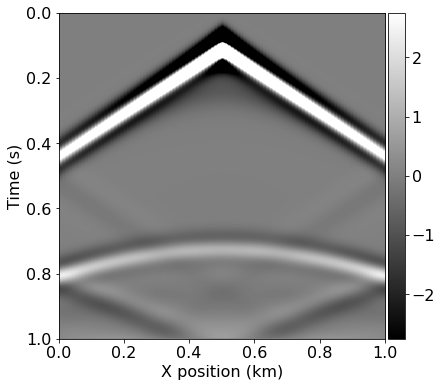

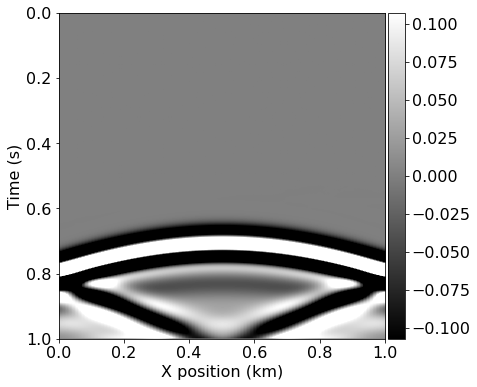

In [3]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d , _, _ = solver.forward(vp=model.vp)

# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

#NBVAL_IGNORE_OUTPUT
# Plot shot record for true and smooth velocity model and the difference
from examples.seismic import plot_shotrecord

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)



## Imaging with backpropagation

We will now define the imaging operator that computes the adjoint wavefield and correlates it with the forward wavefield.

This operator essentially consists of three components:

*    Stencil update of the adjoint wavefield v
*    Injection of the data residual at the adjoint source (forward receiver) location
*    Correlation of u and v to compute the image contribution at each timestep


In [4]:
# Define gradient operator for imaging
from devito import TimeFunction, Operator, Eq, solve
from examples.seismic import PointSource

def ImagingOperator(model, image):
    # Define the wavefield with the size of the model and the time dimension
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)

    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=4,
                     save=geometry.nt)
    
    # Define the wave equation, but with a negated damping term
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T

    # Use `solve` to rearrange the equation into a stencil expression
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    # Define residual injection at the location of the forward receivers
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)

    # Correlate u and v for the current time step and add it to the image
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update],
                    subs=model.spacing_map)




## Implementation of the imaging loop

The forward wave-equation is solved forward in time while the adjoint wave-equation is solved in a reversed time order. Therefore, the correlation of these two fields over time requires to store one of the two fields. The computational procedure for imaging follows:

*    Simulate the forward wave-equation with the background velocity model to get the synthetic data and save the full wavefield 

*    Compute the data residual
*    Back-propagate the data residual and compute on the fly the image contribution at each time step.

This procedure is applied to multiple source positions (shots) and summed to obtain the full image of the subsurface. We can first visualize the varying locations of the sources that we will use.


And we have an image of the subsurface with a strong reflector at the original location.

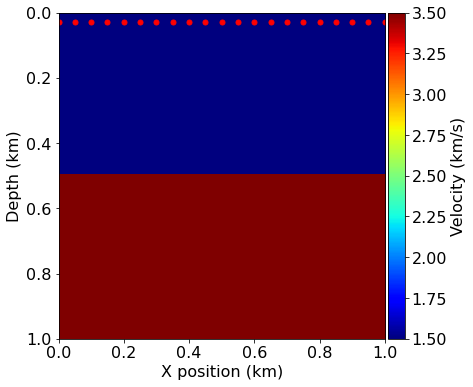

Imaging source 1 out of 21
Imaging source 2 out of 21
Imaging source 3 out of 21
Imaging source 4 out of 21
Imaging source 5 out of 21
Imaging source 6 out of 21
Imaging source 7 out of 21
Imaging source 8 out of 21
Imaging source 9 out of 21
Imaging source 10 out of 21
Imaging source 11 out of 21
Imaging source 12 out of 21
Imaging source 13 out of 21
Imaging source 14 out of 21
Imaging source 15 out of 21
Imaging source 16 out of 21
Imaging source 17 out of 21
Imaging source 18 out of 21
Imaging source 19 out of 21
Imaging source 20 out of 21
Imaging source 21 out of 21


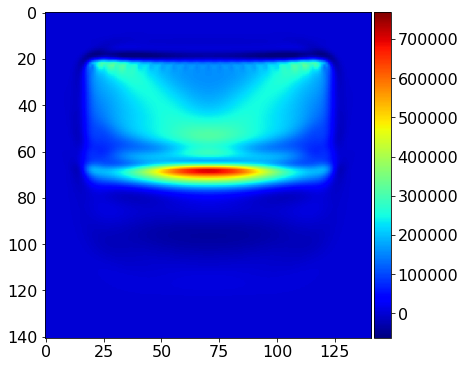

In [5]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., 1000, num=nshots)
source_locations[:, 1] = 30.

plot_velocity(model, source=source_locations)

# Run imaging loop over shots
from devito import Function

# Create image symbol and instantiate the previously defined imaging operator
image = Function(name='image', grid=model.grid)
op_imaging = ImagingOperator(model, image)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    
    # Update source location
    geometry.src_positions[0, :] = source_locations[i, :]

    # Generate synthetic data from true model
    true_d, _, _ = solver.forward(vp=model.vp)
    
    # Compute smooth data and full forward wavefield u0
    smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)
    
    # Compute gradient from the data residual  
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=4)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, 
               residual=residual)

plot_image(image.data, cmap="jet")
